In [10]:
import __init__
import os, argparse, yaml, numpy as np
import sys
# sys.path.append("C:\\Users\\pojzi\\Programovanie\\bakalarka\\PointNeXt\\")
                
from torch import multiprocessing as mp
from examples.classification.my_train import main as train
from examples.classification.pretrain import main as pretrain
from openpoints.utils import EasyConfig, dist_utils, find_free_port, generate_exp_directory, resume_exp_directory, Wandb
import sys

# parser = argparse.ArgumentParser('S3DIS scene segmentation training')
# parser.add_argument('--cfg', type=str, required=True, help='config file')
# parser.add_argument('--profile', action='store_true', default=False, help='set to True to profile speed')
# args, opts = parser.parse_known_args()

opts = []

class Args:
    def __init__(self, cfg, profile):
        self.cfg = cfg
        self.profile = profile



def run(num_classes, num_points, train_mode, epochs=100):

    run_name = f"modelnet39ply2048_neutral_{num_points}_{num_classes}_{train_mode}"

    base_log_path = "C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048/{}"

    run_cfg_path = r"C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048/{}/cfg.yaml".format(run_name)

    modelnet_cfg_path = '../../cfgs/modelnet40ply2048/pointnext-s.yaml'

    args = Args(cfg=modelnet_cfg_path, profile=False)
    # args = Args(cfg="C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048/20240418-181925-/cfg.yaml", profile=False)
    cfg = EasyConfig()
    cfg.figures_path = base_log_path.format(run_name)


    # stop here

    cfg.load(args.cfg, recursive=True)
    cfg.model.cls_args.num_classes
    cfg.batch_size = 5
    cfg.num_classes = num_classes
    cfg.epochs = epochs
    cfg.num_points = num_points

    cfg.train_mode = train_mode

    cfg.run_name = run_name


    cfg.pretrained_path = None
    # cfg.pretrained_path = "C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048/20240418-175009-/checkpoint" + "/20240418-175009-_ckpt_best.pth"
    #cfg.pretrained_path = "C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048/{}/checkpoint/{}_ckpt_best.pth".format(cfg.run_name, cfg.run_name)

    if cfg.pretrained_path is not None:
        cfg.mode = 'resume'
    else:
        cfg.mode = 'train'

    # cfg.update(opts)
    if cfg.seed is None:
        cfg.seed = np.random.randint(1, 10000)

    # init distributed env first, since logger depends on the dist info.
    cfg.rank, cfg.world_size, cfg.distributed, cfg.mp = dist_utils.get_dist_info(cfg)
    cfg.sync_bn = cfg.world_size > 1

    # init log dir
    cfg.task_name = args.cfg.split('.')[-2].split('/')[-2]
    cfg.exp_name = args.cfg.split('.')[-2].split('/')[-1]
    tags = [
        cfg.task_name,  # task name (the folder of name under ./cfgs
        cfg.mode,
        cfg.exp_name,  # cfg file name
        f'ngpus{cfg.world_size}',
        f'seed{cfg.seed}',
    ]

    opt_list = [] # for checking experiment configs from logging file
    for i, opt in enumerate(opts):
        if 'rank' not in opt and 'dir' not in opt and 'root' not in opt and 'pretrain' not in opt and 'path' not in opt and 'wandb' not in opt and '/' not in opt:
            opt_list.append(opt)
    cfg.root_dir = os.path.join(cfg.root_dir, cfg.task_name)
    cfg.opts = '-'.join(opt_list)


    # added here 
    # cfg.mode = 'test'


    if cfg.mode in ['resume', 'val', 'test']:
        resume_exp_directory(cfg, pretrained_path=cfg.pretrained_path)
        cfg.wandb.tags = [cfg.mode]
    else:  # resume from the existing ckpt and reuse the folder.
        generate_exp_directory(cfg, tags, additional_id=os.environ.get('MASTER_PORT', None), run_name=cfg.run_name)
        cfg.wandb.tags = tags

    os.environ["JOB_LOG_DIR"] = cfg.log_dir
    cfg_path = os.path.join(cfg.run_dir, "cfg.yaml")
    with open(cfg_path, 'w') as f:
        yaml.dump(cfg, f, indent=2)
        os.system('copy {} {}'.format(args.cfg, cfg.run_dir))

    cfg.cfg_path = cfg_path
    cfg.wandb.name = cfg.run_name

    # return cfg

    if cfg.mode == 'pretrain':
        main = pretrain
    else:
        main = train
    # multi processing.
    if cfg.mp:
        port = find_free_port()
        cfg.dist_url = f"tcp://localhost:{port}"
        print('using mp spawn for distributed training')
        mp.spawn(main, nprocs=cfg.world_size, args=(cfg, args.profile))
    else:
        result = main(0, cfg, profile=args.profile)
        return result

# num_classes = 100
# num_points = 1024

# output_file = open("train_results.txt", "w")

# for num_classes, mode, epochs, in zip([50, 10, 10], ["neutral-neutral", "neutral-modified", "modified-modified"], [50, 100, 300]):
#     if num_classes == 50: 
#         continue
#     for num_points in [1024, 2048, 4096, 8192]:
#         print(f"num_classes: {num_classes}, num_points: {num_points}, mode: {mode}, epochs: {epochs}\n")
#         run(num_classes, num_points, mode, epochs=50)
#         to_write = f"num_classes: {num_classes}, num_points: {num_points}, mode: {mode}, epochs: {epochs}\n"
#         output_file.write(to_write)

# output_file.close()

# neutral-neutral
# run (10, 1024, "neutral-neutral", epochs=50)
# clear output of jupyter

# run (50, 1024, "neutral-neutral", epochs=50)
# run (50, 2048, "neutral-neutral", epochs=50)
# run (50, 4096, "neutral-neutral", epochs=50)
# run (50, 8192, "neutral-neutral", epochs=50)

# # neutral-modified
# result = run( 10, 1024, "neutral-modified", epochs=100)
# run (10, 2048, "neutral-modified", epochs=100)
# run (10, 4096, "neutral-modified", epochs=100)
# run (10, 8192, "neutral-modified", epochs=100)

# # modified-modified
run( 10, 1024, "modified-modified", epochs=300)
# run (10, 2048, "modified-modified", epochs=300)
# run (10, 4096, "modified-modified", epochs=300)
# run (10, 8192, "modified-modified", epochs=300)

# run(90, 1024, epochs=2)

launch mp with 1 GPUs, current rank: 0
Generating exp directory  modelnet39ply2048_neutral_1024_10_modified-modified
Dostal som sa sem
C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/data_faces
10 10
dict_keys(['pos', 'x', 'y', 'exp'])
Attribute not found:  epoch


Train Epoch [1/300] Loss 3.163 Acc 0.04: 100%|██████████| 16/16 [00:00<00:00, 31.81it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 115.97it/s]


Attribute not found:  epoch


Train Epoch [2/300] Loss 2.810 Acc 0.09: 100%|██████████| 16/16 [00:00<00:00, 32.96it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 106.02it/s]


Attribute not found:  epoch


Train Epoch [3/300] Loss 2.436 Acc 0.18: 100%|██████████| 16/16 [00:00<00:00, 31.49it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 77.56it/s]


Attribute not found:  epoch


Train Epoch [4/300] Loss 2.620 Acc 0.16: 100%|██████████| 16/16 [00:00<00:00, 31.11it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 91.10it/s]


Attribute not found:  epoch


Train Epoch [5/300] Loss 2.784 Acc 0.04: 100%|██████████| 16/16 [00:00<00:00, 29.17it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 103.18it/s]


Attribute not found:  epoch


Train Epoch [6/300] Loss 2.566 Acc 0.09: 100%|██████████| 16/16 [00:00<00:00, 33.53it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 110.14it/s]


Attribute not found:  epoch


Train Epoch [7/300] Loss 2.175 Acc 0.11: 100%|██████████| 16/16 [00:00<00:00, 28.96it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 84.31it/s]


Attribute not found:  epoch


Train Epoch [8/300] Loss 2.485 Acc 0.04: 100%|██████████| 16/16 [00:00<00:00, 33.37it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 105.20it/s]


Attribute not found:  epoch


Train Epoch [9/300] Loss 2.520 Acc 0.04: 100%|██████████| 16/16 [00:00<00:00, 33.35it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 98.53it/s]


Attribute not found:  epoch


Train Epoch [10/300] Loss 2.575 Acc 0.11: 100%|██████████| 16/16 [00:00<00:00, 32.23it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 105.07it/s]


Attribute not found:  epoch


Train Epoch [11/300] Loss 2.527 Acc 0.13: 100%|██████████| 16/16 [00:00<00:00, 32.43it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 83.74it/s]


Attribute not found:  epoch


Train Epoch [12/300] Loss 2.589 Acc 0.22: 100%|██████████| 16/16 [00:00<00:00, 31.66it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 92.75it/s]


Attribute not found:  epoch


Train Epoch [13/300] Loss 2.622 Acc 0.05: 100%|██████████| 16/16 [00:00<00:00, 29.19it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 99.75it/s]


Attribute not found:  epoch


Train Epoch [14/300] Loss 2.485 Acc 0.07: 100%|██████████| 16/16 [00:00<00:00, 31.98it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 96.99it/s] 


Attribute not found:  epoch


Train Epoch [15/300] Loss 2.343 Acc 0.11: 100%|██████████| 16/16 [00:00<00:00, 32.57it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 79.39it/s]


Attribute not found:  epoch


Train Epoch [16/300] Loss 2.569 Acc 0.11: 100%|██████████| 16/16 [00:00<00:00, 32.13it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 99.20it/s]


Attribute not found:  epoch


Train Epoch [17/300] Loss 2.406 Acc 0.16: 100%|██████████| 16/16 [00:00<00:00, 32.51it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 89.54it/s]


Attribute not found:  epoch


Train Epoch [18/300] Loss 2.589 Acc 0.22: 100%|██████████| 16/16 [00:00<00:00, 30.95it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 85.06it/s]


Attribute not found:  epoch


Train Epoch [19/300] Loss 2.464 Acc 0.16: 100%|██████████| 16/16 [00:00<00:00, 32.07it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 97.98it/s]


Attribute not found:  epoch


Train Epoch [20/300] Loss 2.256 Acc 0.13: 100%|██████████| 16/16 [00:00<00:00, 29.16it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 96.53it/s]


Attribute not found:  epoch


Train Epoch [21/300] Loss 2.374 Acc 0.13: 100%|██████████| 16/16 [00:00<00:00, 32.66it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 83.81it/s]


Attribute not found:  epoch


Train Epoch [22/300] Loss 2.481 Acc 0.05: 100%|██████████| 16/16 [00:00<00:00, 28.98it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 83.10it/s]


Attribute not found:  epoch


Train Epoch [23/300] Loss 2.493 Acc 0.15: 100%|██████████| 16/16 [00:00<00:00, 30.35it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 83.47it/s]


Attribute not found:  epoch


Train Epoch [24/300] Loss 2.597 Acc 0.20: 100%|██████████| 16/16 [00:00<00:00, 28.72it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 85.30it/s]


Attribute not found:  epoch


Train Epoch [25/300] Loss 2.439 Acc 0.09: 100%|██████████| 16/16 [00:00<00:00, 30.37it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 84.80it/s]


Attribute not found:  epoch


Train Epoch [26/300] Loss 2.453 Acc 0.15: 100%|██████████| 16/16 [00:00<00:00, 30.78it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 85.45it/s]


Attribute not found:  epoch


Train Epoch [27/300] Loss 2.572 Acc 0.13: 100%|██████████| 16/16 [00:00<00:00, 30.75it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 86.45it/s]


Attribute not found:  epoch


Train Epoch [28/300] Loss 2.448 Acc 0.18: 100%|██████████| 16/16 [00:00<00:00, 27.35it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 84.15it/s]


Attribute not found:  epoch


Train Epoch [29/300] Loss 2.546 Acc 0.09: 100%|██████████| 16/16 [00:00<00:00, 30.09it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 83.77it/s]


Attribute not found:  epoch


Train Epoch [30/300] Loss 2.487 Acc 0.15: 100%|██████████| 16/16 [00:00<00:00, 30.62it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 83.48it/s]


Attribute not found:  epoch


Train Epoch [31/300] Loss 2.495 Acc 0.16: 100%|██████████| 16/16 [00:00<00:00, 30.20it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 84.95it/s]


Attribute not found:  epoch


Train Epoch [32/300] Loss 2.522 Acc 0.13: 100%|██████████| 16/16 [00:00<00:00, 28.96it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 74.71it/s]


Attribute not found:  epoch


Train Epoch [33/300] Loss 2.489 Acc 0.13: 100%|██████████| 16/16 [00:00<00:00, 29.22it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 74.85it/s]


Attribute not found:  epoch


Train Epoch [34/300] Loss 2.393 Acc 0.16: 100%|██████████| 16/16 [00:00<00:00, 27.94it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 75.22it/s]


Attribute not found:  epoch


Train Epoch [35/300] Loss 2.568 Acc 0.16: 100%|██████████| 16/16 [00:00<00:00, 29.02it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 74.84it/s]


Attribute not found:  epoch


Train Epoch [36/300] Loss 2.465 Acc 0.18: 100%|██████████| 16/16 [00:00<00:00, 26.06it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 71.39it/s]


Attribute not found:  epoch


Train Epoch [37/300] Loss 2.542 Acc 0.18: 100%|██████████| 16/16 [00:00<00:00, 27.15it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 76.09it/s]


Attribute not found:  epoch


Train Epoch [38/300] Loss 2.606 Acc 0.15: 100%|██████████| 16/16 [00:00<00:00, 28.30it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 74.51it/s]


Attribute not found:  epoch


Train Epoch [39/300] Loss 2.487 Acc 0.20: 100%|██████████| 16/16 [00:00<00:00, 29.29it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 80.90it/s]


Attribute not found:  epoch


Train Epoch [40/300] Loss 2.402 Acc 0.18: 100%|██████████| 16/16 [00:00<00:00, 25.95it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 74.71it/s]


Attribute not found:  epoch


Train Epoch [41/300] Loss 2.403 Acc 0.25: 100%|██████████| 16/16 [00:00<00:00, 28.03it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 75.44it/s]


Attribute not found:  epoch


Train Epoch [42/300] Loss 2.538 Acc 0.20: 100%|██████████| 16/16 [00:00<00:00, 28.03it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 77.24it/s]


Attribute not found:  epoch


Train Epoch [43/300] Loss 2.395 Acc 0.22: 100%|██████████| 16/16 [00:00<00:00, 27.04it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 63.33it/s]


Attribute not found:  epoch


Train Epoch [44/300] Loss 2.539 Acc 0.18: 100%|██████████| 16/16 [00:00<00:00, 28.35it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 70.06it/s]


Attribute not found:  epoch


Train Epoch [45/300] Loss 2.502 Acc 0.20: 100%|██████████| 16/16 [00:00<00:00, 26.27it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 76.78it/s]


Attribute not found:  epoch


Train Epoch [46/300] Loss 2.435 Acc 0.25: 100%|██████████| 16/16 [00:00<00:00, 27.89it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 74.20it/s]


Attribute not found:  epoch


Train Epoch [47/300] Loss 2.628 Acc 0.24: 100%|██████████| 16/16 [00:00<00:00, 26.79it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 74.63it/s]


Attribute not found:  epoch


Train Epoch [48/300] Loss 2.439 Acc 0.25: 100%|██████████| 16/16 [00:00<00:00, 28.11it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 77.24it/s]


Attribute not found:  epoch


Train Epoch [49/300] Loss 2.522 Acc 0.24: 100%|██████████| 16/16 [00:00<00:00, 27.19it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 71.12it/s]


Attribute not found:  epoch


Train Epoch [50/300] Loss 2.483 Acc 0.20: 100%|██████████| 16/16 [00:00<00:00, 26.22it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 76.75it/s]


Attribute not found:  epoch


Train Epoch [51/300] Loss 2.440 Acc 0.24: 100%|██████████| 16/16 [00:00<00:00, 29.54it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 76.44it/s]


Attribute not found:  epoch


Train Epoch [52/300] Loss 2.396 Acc 0.25: 100%|██████████| 16/16 [00:00<00:00, 28.74it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 73.78it/s]


Attribute not found:  epoch


Train Epoch [53/300] Loss 2.327 Acc 0.24: 100%|██████████| 16/16 [00:00<00:00, 28.72it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 75.84it/s]


Attribute not found:  epoch


Train Epoch [54/300] Loss 2.368 Acc 0.27: 100%|██████████| 16/16 [00:00<00:00, 28.33it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 76.85it/s]


Attribute not found:  epoch


Train Epoch [55/300] Loss 2.686 Acc 0.25: 100%|██████████| 16/16 [00:00<00:00, 29.73it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 67.41it/s]


Attribute not found:  epoch


Train Epoch [56/300] Loss 2.320 Acc 0.29: 100%|██████████| 16/16 [00:00<00:00, 28.07it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 76.72it/s]


Attribute not found:  epoch


Train Epoch [57/300] Loss 2.547 Acc 0.22: 100%|██████████| 16/16 [00:00<00:00, 27.45it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 78.84it/s]


Attribute not found:  epoch


Train Epoch [58/300] Loss 2.691 Acc 0.27: 100%|██████████| 16/16 [00:00<00:00, 29.56it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 67.22it/s]


Attribute not found:  epoch


Train Epoch [59/300] Loss 2.571 Acc 0.27: 100%|██████████| 16/16 [00:00<00:00, 26.28it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 76.66it/s]


Attribute not found:  epoch


Train Epoch [60/300] Loss 2.627 Acc 0.29: 100%|██████████| 16/16 [00:00<00:00, 23.98it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 76.71it/s]


Attribute not found:  epoch


Train Epoch [61/300] Loss 2.555 Acc 0.35: 100%|██████████| 16/16 [00:00<00:00, 30.62it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 80.09it/s]


Attribute not found:  epoch


Train Epoch [62/300] Loss 2.342 Acc 0.31: 100%|██████████| 16/16 [00:00<00:00, 31.38it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 77.87it/s]


Attribute not found:  epoch


Train Epoch [63/300] Loss 2.457 Acc 0.33: 100%|██████████| 16/16 [00:00<00:00, 31.49it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 76.45it/s]


Attribute not found:  epoch


Train Epoch [64/300] Loss 2.452 Acc 0.31: 100%|██████████| 16/16 [00:00<00:00, 28.46it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 73.78it/s]


Attribute not found:  epoch


Train Epoch [65/300] Loss 2.454 Acc 0.35: 100%|██████████| 16/16 [00:00<00:00, 29.10it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 73.21it/s]


Attribute not found:  epoch


Train Epoch [66/300] Loss 2.463 Acc 0.25: 100%|██████████| 16/16 [00:00<00:00, 25.96it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 73.20it/s]


Attribute not found:  epoch


Train Epoch [67/300] Loss 2.365 Acc 0.33: 100%|██████████| 16/16 [00:00<00:00, 29.63it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 79.85it/s]


Attribute not found:  epoch


Train Epoch [68/300] Loss 2.393 Acc 0.35: 100%|██████████| 16/16 [00:00<00:00, 30.54it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 77.37it/s]


Attribute not found:  epoch


Train Epoch [69/300] Loss 2.262 Acc 0.33: 100%|██████████| 16/16 [00:00<00:00, 22.19it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 73.93it/s]


Attribute not found:  epoch


Train Epoch [70/300] Loss 2.347 Acc 0.27: 100%|██████████| 16/16 [00:00<00:00, 27.67it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 77.27it/s]


Attribute not found:  epoch


Train Epoch [71/300] Loss 2.397 Acc 0.31: 100%|██████████| 16/16 [00:00<00:00, 29.84it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 79.40it/s]


Attribute not found:  epoch


Train Epoch [72/300] Loss 2.407 Acc 0.31: 100%|██████████| 16/16 [00:00<00:00, 30.41it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 77.26it/s]


Attribute not found:  epoch


Train Epoch [73/300] Loss 2.531 Acc 0.40: 100%|██████████| 16/16 [00:00<00:00, 28.69it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 77.88it/s]


Attribute not found:  epoch


Train Epoch [74/300] Loss 2.221 Acc 0.44: 100%|██████████| 16/16 [00:00<00:00, 30.37it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 79.99it/s]


Attribute not found:  epoch


Train Epoch [75/300] Loss 2.363 Acc 0.38: 100%|██████████| 16/16 [00:00<00:00, 30.25it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 67.76it/s]


Attribute not found:  epoch


Train Epoch [76/300] Loss 2.224 Acc 0.31: 100%|██████████| 16/16 [00:00<00:00, 23.42it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 65.08it/s]


Attribute not found:  epoch


Train Epoch [77/300] Loss 2.315 Acc 0.36: 100%|██████████| 16/16 [00:00<00:00, 23.79it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 64.67it/s]


Attribute not found:  epoch


Train Epoch [78/300] Loss 2.325 Acc 0.44: 100%|██████████| 16/16 [00:00<00:00, 23.42it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 64.25it/s]


Attribute not found:  epoch


Train Epoch [79/300] Loss 2.350 Acc 0.38: 100%|██████████| 16/16 [00:00<00:00, 23.44it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 65.77it/s]


Attribute not found:  epoch


Train Epoch [80/300] Loss 2.419 Acc 0.36: 100%|██████████| 16/16 [00:00<00:00, 23.60it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 53.43it/s]


Attribute not found:  epoch


Train Epoch [81/300] Loss 2.364 Acc 0.42: 100%|██████████| 16/16 [00:00<00:00, 21.74it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 58.28it/s]


Attribute not found:  epoch


Train Epoch [82/300] Loss 2.213 Acc 0.40: 100%|██████████| 16/16 [00:00<00:00, 22.99it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 65.19it/s]


Attribute not found:  epoch


Train Epoch [83/300] Loss 2.179 Acc 0.42: 100%|██████████| 16/16 [00:00<00:00, 22.86it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 63.96it/s]


Attribute not found:  epoch


Train Epoch [84/300] Loss 2.247 Acc 0.33: 100%|██████████| 16/16 [00:00<00:00, 22.83it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 63.19it/s]


Attribute not found:  epoch


Train Epoch [85/300] Loss 2.268 Acc 0.44: 100%|██████████| 16/16 [00:00<00:00, 22.58it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 64.11it/s]


Attribute not found:  epoch


Train Epoch [86/300] Loss 2.262 Acc 0.35: 100%|██████████| 16/16 [00:00<00:00, 22.42it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 59.24it/s]


Attribute not found:  epoch


Train Epoch [87/300] Loss 2.438 Acc 0.40: 100%|██████████| 16/16 [00:00<00:00, 21.35it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 60.03it/s]


Attribute not found:  epoch


Train Epoch [88/300] Loss 2.524 Acc 0.42: 100%|██████████| 16/16 [00:00<00:00, 21.40it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 59.92it/s]


Attribute not found:  epoch


Train Epoch [89/300] Loss 2.514 Acc 0.51: 100%|██████████| 16/16 [00:00<00:00, 20.90it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 45.10it/s]


Attribute not found:  epoch


Train Epoch [90/300] Loss 2.183 Acc 0.42: 100%|██████████| 16/16 [00:00<00:00, 16.46it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 45.53it/s]


Attribute not found:  epoch


Train Epoch [91/300] Loss 2.405 Acc 0.53: 100%|██████████| 16/16 [00:00<00:00, 16.79it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 45.34it/s]


Attribute not found:  epoch


Train Epoch [92/300] Loss 2.202 Acc 0.38: 100%|██████████| 16/16 [00:00<00:00, 16.73it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 45.68it/s]


Attribute not found:  epoch


Train Epoch [93/300] Loss 2.373 Acc 0.36: 100%|██████████| 16/16 [00:00<00:00, 16.77it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 47.28it/s]


Attribute not found:  epoch


Train Epoch [94/300] Loss 2.168 Acc 0.49: 100%|██████████| 16/16 [00:00<00:00, 16.77it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 44.94it/s]


Attribute not found:  epoch


Train Epoch [95/300] Loss 2.128 Acc 0.38: 100%|██████████| 16/16 [00:00<00:00, 16.75it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 47.10it/s]


Attribute not found:  epoch


Train Epoch [96/300] Loss 2.118 Acc 0.49: 100%|██████████| 16/16 [00:00<00:00, 16.32it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 45.49it/s]


Attribute not found:  epoch


Train Epoch [97/300] Loss 2.297 Acc 0.44: 100%|██████████| 16/16 [00:00<00:00, 16.74it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 45.29it/s]


Attribute not found:  epoch


Train Epoch [98/300] Loss 2.361 Acc 0.47: 100%|██████████| 16/16 [00:00<00:00, 16.88it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 45.92it/s]


Attribute not found:  epoch


Train Epoch [99/300] Loss 2.465 Acc 0.42: 100%|██████████| 16/16 [00:00<00:00, 16.50it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 45.55it/s]


Attribute not found:  epoch


Train Epoch [100/300] Loss 2.366 Acc 0.40: 100%|██████████| 16/16 [00:00<00:00, 16.64it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 47.46it/s]


Attribute not found:  epoch


Train Epoch [101/300] Loss 2.448 Acc 0.45: 100%|██████████| 16/16 [00:00<00:00, 16.55it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 46.11it/s]


Attribute not found:  epoch


Train Epoch [102/300] Loss 2.367 Acc 0.42: 100%|██████████| 16/16 [00:00<00:00, 16.85it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 45.69it/s]


Attribute not found:  epoch


Train Epoch [103/300] Loss 2.384 Acc 0.40: 100%|██████████| 16/16 [00:00<00:00, 16.00it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.25it/s]


Attribute not found:  epoch


Train Epoch [104/300] Loss 2.377 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.15it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.83it/s]


Attribute not found:  epoch


Train Epoch [105/300] Loss 2.331 Acc 0.45: 100%|██████████| 16/16 [00:01<00:00, 10.40it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.34it/s]


Attribute not found:  epoch


Train Epoch [106/300] Loss 2.280 Acc 0.45: 100%|██████████| 16/16 [00:01<00:00, 10.52it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.33it/s]


Attribute not found:  epoch


Train Epoch [107/300] Loss 2.213 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.24it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.10it/s]


Attribute not found:  epoch


Train Epoch [108/300] Loss 2.394 Acc 0.45: 100%|██████████| 16/16 [00:00<00:00, 20.41it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 57.04it/s]


Attribute not found:  epoch


Train Epoch [109/300] Loss 2.172 Acc 0.44: 100%|██████████| 16/16 [00:01<00:00, 12.34it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 25.21it/s]


Attribute not found:  epoch


Train Epoch [110/300] Loss 2.390 Acc 0.47: 100%|██████████| 16/16 [00:01<00:00, 11.10it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 25.53it/s]


Attribute not found:  epoch


Train Epoch [111/300] Loss 2.135 Acc 0.44: 100%|██████████| 16/16 [00:01<00:00, 11.02it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 25.03it/s]


Attribute not found:  epoch


Train Epoch [112/300] Loss 2.373 Acc 0.44: 100%|██████████| 16/16 [00:01<00:00, 11.09it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.74it/s]


Attribute not found:  epoch


Train Epoch [113/300] Loss 2.258 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 11.07it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.64it/s]


Attribute not found:  epoch


Train Epoch [114/300] Loss 2.364 Acc 0.47: 100%|██████████| 16/16 [00:00<00:00, 20.24it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 56.97it/s]


Attribute not found:  epoch


Train Epoch [115/300] Loss 2.307 Acc 0.53: 100%|██████████| 16/16 [00:00<00:00, 18.08it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 44.56it/s]


Attribute not found:  epoch


Train Epoch [116/300] Loss 2.242 Acc 0.51: 100%|██████████| 16/16 [00:00<00:00, 16.38it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 44.53it/s]


Attribute not found:  epoch


Train Epoch [117/300] Loss 2.357 Acc 0.47: 100%|██████████| 16/16 [00:00<00:00, 16.11it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 44.96it/s]


Attribute not found:  epoch


Train Epoch [118/300] Loss 2.249 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00, 15.74it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 37.99it/s]


Attribute not found:  epoch


Train Epoch [119/300] Loss 2.080 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 14.15it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 38.66it/s]


Attribute not found:  epoch


Train Epoch [120/300] Loss 2.472 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00, 14.22it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 37.23it/s]


Attribute not found:  epoch


Train Epoch [121/300] Loss 2.139 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00, 14.20it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 38.23it/s]


Attribute not found:  epoch


Train Epoch [122/300] Loss 2.357 Acc 0.44: 100%|██████████| 16/16 [00:01<00:00, 14.30it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 37.84it/s]


Attribute not found:  epoch


Train Epoch [123/300] Loss 2.461 Acc 0.47: 100%|██████████| 16/16 [00:01<00:00, 12.07it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 26.67it/s]


Attribute not found:  epoch


Train Epoch [124/300] Loss 2.204 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 11.53it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 27.01it/s]


Attribute not found:  epoch


Train Epoch [125/300] Loss 2.266 Acc 0.47: 100%|██████████| 16/16 [00:01<00:00, 11.52it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 27.11it/s]


Attribute not found:  epoch


Train Epoch [126/300] Loss 2.186 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 11.52it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 27.44it/s]


Attribute not found:  epoch


Train Epoch [127/300] Loss 2.243 Acc 0.45: 100%|██████████| 16/16 [00:01<00:00, 11.38it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 26.99it/s]


Attribute not found:  epoch


Train Epoch [128/300] Loss 2.106 Acc 0.44: 100%|██████████| 16/16 [00:01<00:00, 11.64it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 28.00it/s]


Attribute not found:  epoch


Train Epoch [129/300] Loss 2.248 Acc 0.45: 100%|██████████| 16/16 [00:01<00:00, 10.99it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 26.30it/s]


Attribute not found:  epoch


Train Epoch [130/300] Loss 2.238 Acc 0.40: 100%|██████████| 16/16 [00:01<00:00, 10.35it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 27.62it/s]


Attribute not found:  epoch


Train Epoch [131/300] Loss 2.433 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 11.32it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 26.30it/s]


Attribute not found:  epoch


Train Epoch [132/300] Loss 2.331 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00, 10.77it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 27.14it/s]


Attribute not found:  epoch


Train Epoch [133/300] Loss 2.215 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.20it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 25.19it/s]


Attribute not found:  epoch


Train Epoch [134/300] Loss 2.415 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00, 10.12it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 25.90it/s]


Attribute not found:  epoch


Train Epoch [135/300] Loss 2.382 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.69it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 26.61it/s]


Attribute not found:  epoch


Train Epoch [136/300] Loss 2.189 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 11.39it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 26.72it/s]


Attribute not found:  epoch


Train Epoch [137/300] Loss 2.182 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00, 10.96it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 27.12it/s]


Attribute not found:  epoch


Train Epoch [138/300] Loss 2.134 Acc 0.47: 100%|██████████| 16/16 [00:01<00:00, 11.42it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 26.78it/s]


Attribute not found:  epoch


Train Epoch [139/300] Loss 2.293 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.83it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.21it/s]


Attribute not found:  epoch


Train Epoch [140/300] Loss 2.236 Acc 0.42: 100%|██████████| 16/16 [00:01<00:00, 10.36it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.03it/s]


Attribute not found:  epoch


Train Epoch [141/300] Loss 2.254 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00, 10.43it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.19it/s]


Attribute not found:  epoch


Train Epoch [142/300] Loss 2.019 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00, 10.11it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.35it/s]


Attribute not found:  epoch


Train Epoch [143/300] Loss 2.358 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.17it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.05it/s]


Attribute not found:  epoch


Train Epoch [144/300] Loss 2.494 Acc 0.45: 100%|██████████| 16/16 [00:01<00:00, 10.33it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.96it/s]


Attribute not found:  epoch


Train Epoch [145/300] Loss 2.221 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.34it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.84it/s]


Attribute not found:  epoch


Train Epoch [146/300] Loss 2.113 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00, 10.28it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.07it/s]


Attribute not found:  epoch


Train Epoch [147/300] Loss 2.063 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.32it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.60it/s]


Attribute not found:  epoch


Train Epoch [148/300] Loss 2.096 Acc 0.47: 100%|██████████| 16/16 [00:01<00:00, 10.27it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.00it/s]


Attribute not found:  epoch


Train Epoch [149/300] Loss 2.206 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.29it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.12it/s]


Attribute not found:  epoch


Train Epoch [150/300] Loss 2.459 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00, 10.28it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.20it/s]


Attribute not found:  epoch


Train Epoch [151/300] Loss 2.226 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  9.96it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.01it/s]


Attribute not found:  epoch


Train Epoch [152/300] Loss 2.305 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00, 10.22it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.09it/s]


Attribute not found:  epoch


Train Epoch [153/300] Loss 2.454 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.40it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.86it/s]


Attribute not found:  epoch


Train Epoch [154/300] Loss 2.212 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00, 10.31it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.99it/s]


Attribute not found:  epoch


Train Epoch [155/300] Loss 2.599 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.50it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.81it/s]


Attribute not found:  epoch


Train Epoch [156/300] Loss 2.303 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.30it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.00it/s]


Attribute not found:  epoch


Train Epoch [157/300] Loss 2.263 Acc 0.47: 100%|██████████| 16/16 [00:01<00:00, 10.36it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.15it/s]


Attribute not found:  epoch


Train Epoch [158/300] Loss 2.125 Acc 0.47: 100%|██████████| 16/16 [00:01<00:00, 10.27it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.01it/s]


Attribute not found:  epoch


Train Epoch [159/300] Loss 2.251 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00, 10.39it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.84it/s]


Attribute not found:  epoch


Train Epoch [160/300] Loss 2.105 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.28it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.34it/s]


Attribute not found:  epoch


Train Epoch [161/300] Loss 2.120 Acc 0.47: 100%|██████████| 16/16 [00:01<00:00, 10.23it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.16it/s]


Attribute not found:  epoch


Train Epoch [162/300] Loss 2.279 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00,  9.28it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.52it/s]


Attribute not found:  epoch


Train Epoch [163/300] Loss 2.329 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.02it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.49it/s]


Attribute not found:  epoch


Train Epoch [164/300] Loss 2.323 Acc 0.47: 100%|██████████| 16/16 [00:01<00:00, 10.21it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.54it/s]


Attribute not found:  epoch


Train Epoch [165/300] Loss 2.302 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00, 10.31it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.76it/s]


Attribute not found:  epoch


Train Epoch [166/300] Loss 2.179 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00, 10.03it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.75it/s]


Attribute not found:  epoch


Train Epoch [167/300] Loss 1.959 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00, 10.29it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.52it/s]


Attribute not found:  epoch


Train Epoch [168/300] Loss 2.266 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  9.88it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.93it/s]


Attribute not found:  epoch


Train Epoch [169/300] Loss 2.201 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00, 10.23it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.39it/s]


Attribute not found:  epoch


Train Epoch [170/300] Loss 2.426 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00,  9.89it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.49it/s]


Attribute not found:  epoch


Train Epoch [171/300] Loss 2.339 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.04it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.74it/s]


Attribute not found:  epoch


Train Epoch [172/300] Loss 2.091 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00, 10.14it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.04it/s]


Attribute not found:  epoch


Train Epoch [173/300] Loss 2.371 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00,  9.91it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.77it/s]


Attribute not found:  epoch


Train Epoch [174/300] Loss 2.392 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00,  9.79it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.36it/s]


Attribute not found:  epoch


Train Epoch [175/300] Loss 2.353 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00,  9.37it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.35it/s]


Attribute not found:  epoch


Train Epoch [176/300] Loss 2.264 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00,  9.80it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.02it/s]


Attribute not found:  epoch


Train Epoch [177/300] Loss 2.375 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00, 10.23it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.36it/s]


Attribute not found:  epoch


Train Epoch [178/300] Loss 2.213 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00,  9.84it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.89it/s]


Attribute not found:  epoch


Train Epoch [179/300] Loss 2.496 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00, 10.17it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.08it/s]


Attribute not found:  epoch


Train Epoch [180/300] Loss 2.389 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.26it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.29it/s]


Attribute not found:  epoch


Train Epoch [181/300] Loss 2.436 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00, 10.24it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.22it/s]


Attribute not found:  epoch


Train Epoch [182/300] Loss 1.966 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00, 10.24it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.64it/s]


Attribute not found:  epoch


Train Epoch [183/300] Loss 2.484 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.31it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.25it/s]


Attribute not found:  epoch


Train Epoch [184/300] Loss 2.401 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00, 10.18it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.42it/s]


Attribute not found:  epoch


Train Epoch [185/300] Loss 2.230 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00,  9.31it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.82it/s]


Attribute not found:  epoch


Train Epoch [186/300] Loss 2.408 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00,  9.13it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.53it/s]


Attribute not found:  epoch


Train Epoch [187/300] Loss 2.316 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  9.24it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.49it/s]


Attribute not found:  epoch


Train Epoch [188/300] Loss 2.135 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00,  9.33it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 24.23it/s]


Attribute not found:  epoch


Train Epoch [189/300] Loss 2.059 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.32it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.26it/s]


Attribute not found:  epoch


Train Epoch [190/300] Loss 2.138 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00, 10.09it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.92it/s]


Attribute not found:  epoch


Train Epoch [191/300] Loss 2.172 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.49it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.32it/s]


Attribute not found:  epoch


Train Epoch [192/300] Loss 2.376 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00,  9.66it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.04it/s]


Attribute not found:  epoch


Train Epoch [193/300] Loss 2.268 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.03it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.33it/s]


Attribute not found:  epoch


Train Epoch [194/300] Loss 2.504 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00,  9.76it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.48it/s]


Attribute not found:  epoch


Train Epoch [195/300] Loss 2.217 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00,  9.23it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.39it/s]


Attribute not found:  epoch


Train Epoch [196/300] Loss 2.119 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00,  9.74it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.26it/s]


Attribute not found:  epoch


Train Epoch [197/300] Loss 2.377 Acc 0.62: 100%|██████████| 16/16 [00:01<00:00,  9.53it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.12it/s]


Attribute not found:  epoch


Train Epoch [198/300] Loss 2.206 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  9.91it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.66it/s]


Attribute not found:  epoch


Train Epoch [199/300] Loss 2.202 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00,  9.32it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.11it/s]


Attribute not found:  epoch


Train Epoch [200/300] Loss 2.234 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  8.96it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.19it/s]


Attribute not found:  epoch


Train Epoch [201/300] Loss 2.404 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00,  9.58it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.24it/s]


Attribute not found:  epoch


Train Epoch [202/300] Loss 2.250 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  9.90it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.36it/s]


Attribute not found:  epoch


Train Epoch [203/300] Loss 2.183 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  9.71it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.33it/s]


Attribute not found:  epoch


Train Epoch [204/300] Loss 2.414 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  8.98it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.59it/s]


Attribute not found:  epoch


Train Epoch [205/300] Loss 2.102 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00,  9.08it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.22it/s]


Attribute not found:  epoch


Train Epoch [206/300] Loss 2.291 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00,  9.77it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.99it/s]


Attribute not found:  epoch


Train Epoch [207/300] Loss 1.898 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  9.67it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.74it/s]


Attribute not found:  epoch


Train Epoch [208/300] Loss 2.233 Acc 0.62: 100%|██████████| 16/16 [00:01<00:00,  8.80it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.77it/s]


Attribute not found:  epoch


Train Epoch [209/300] Loss 2.214 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  8.79it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.13it/s]


Attribute not found:  epoch


Train Epoch [210/300] Loss 2.199 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  8.77it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.43it/s]


Attribute not found:  epoch


Train Epoch [211/300] Loss 2.344 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.93it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.72it/s]


Attribute not found:  epoch


Train Epoch [212/300] Loss 2.222 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.94it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.21it/s]


Attribute not found:  epoch


Train Epoch [213/300] Loss 2.338 Acc 0.45: 100%|██████████| 16/16 [00:01<00:00,  9.01it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.18it/s]


Attribute not found:  epoch


Train Epoch [214/300] Loss 2.406 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  8.88it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.42it/s]


Attribute not found:  epoch


Train Epoch [215/300] Loss 2.111 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  9.78it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.87it/s]


Attribute not found:  epoch


Train Epoch [216/300] Loss 1.946 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00,  9.59it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.12it/s]


Attribute not found:  epoch


Train Epoch [217/300] Loss 2.536 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00,  9.97it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.90it/s]


Attribute not found:  epoch


Train Epoch [218/300] Loss 2.206 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  9.85it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.15it/s]


Attribute not found:  epoch


Train Epoch [219/300] Loss 2.076 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00,  8.66it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.49it/s]


Attribute not found:  epoch


Train Epoch [220/300] Loss 2.227 Acc 0.64: 100%|██████████| 16/16 [00:01<00:00,  8.92it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.35it/s]


Attribute not found:  epoch


Train Epoch [221/300] Loss 2.240 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  9.24it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.17it/s]


Attribute not found:  epoch


Train Epoch [222/300] Loss 2.084 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  9.12it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.69it/s]


Attribute not found:  epoch


Train Epoch [223/300] Loss 2.426 Acc 0.47: 100%|██████████| 16/16 [00:01<00:00,  9.43it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.26it/s]


Attribute not found:  epoch


Train Epoch [224/300] Loss 2.114 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00,  8.68it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.54it/s]


Attribute not found:  epoch


Train Epoch [225/300] Loss 2.061 Acc 0.65: 100%|██████████| 16/16 [00:01<00:00,  9.39it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.46it/s]


Attribute not found:  epoch


Train Epoch [226/300] Loss 2.157 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00, 10.01it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.89it/s]


Attribute not found:  epoch


Train Epoch [227/300] Loss 2.154 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00, 10.02it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.64it/s]


Attribute not found:  epoch


Train Epoch [228/300] Loss 2.148 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00, 10.02it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.92it/s]


Attribute not found:  epoch


Train Epoch [229/300] Loss 2.320 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00,  8.90it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.94it/s]


Attribute not found:  epoch


Train Epoch [230/300] Loss 1.979 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  9.98it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.97it/s]


Attribute not found:  epoch


Train Epoch [231/300] Loss 2.085 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.84it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.71it/s]


Attribute not found:  epoch


Train Epoch [232/300] Loss 2.221 Acc 0.62: 100%|██████████| 16/16 [00:01<00:00,  8.63it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.39it/s]


Attribute not found:  epoch


Train Epoch [233/300] Loss 2.181 Acc 0.47: 100%|██████████| 16/16 [00:01<00:00,  9.68it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.55it/s]


Attribute not found:  epoch


Train Epoch [234/300] Loss 2.076 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  9.93it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.61it/s]


Attribute not found:  epoch


Train Epoch [235/300] Loss 2.293 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00, 10.06it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.78it/s]


Attribute not found:  epoch


Train Epoch [236/300] Loss 2.082 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.04it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.72it/s]


Attribute not found:  epoch


Train Epoch [237/300] Loss 2.087 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00, 10.01it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.73it/s]


Attribute not found:  epoch


Train Epoch [238/300] Loss 2.217 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.02it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.55it/s]


Attribute not found:  epoch


Train Epoch [239/300] Loss 2.046 Acc 0.62: 100%|██████████| 16/16 [00:01<00:00, 10.03it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.30it/s]


Attribute not found:  epoch


Train Epoch [240/300] Loss 2.145 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.80it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.43it/s]


Attribute not found:  epoch


Train Epoch [241/300] Loss 2.298 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00,  9.89it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.47it/s]


Attribute not found:  epoch


Train Epoch [242/300] Loss 2.196 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  8.76it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.60it/s]


Attribute not found:  epoch


Train Epoch [243/300] Loss 2.197 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  8.68it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 19.76it/s]


Attribute not found:  epoch


Train Epoch [244/300] Loss 2.126 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  8.83it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.29it/s]


Attribute not found:  epoch


Train Epoch [245/300] Loss 2.293 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00,  9.92it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.71it/s]


Attribute not found:  epoch


Train Epoch [246/300] Loss 2.114 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.08it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.73it/s]


Attribute not found:  epoch


Train Epoch [247/300] Loss 2.097 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.84it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.99it/s]


Attribute not found:  epoch


Train Epoch [248/300] Loss 1.976 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  8.92it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.54it/s]


Attribute not found:  epoch


Train Epoch [249/300] Loss 2.193 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.60it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.74it/s]


Attribute not found:  epoch


Train Epoch [250/300] Loss 2.118 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.02it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.57it/s]


Attribute not found:  epoch


Train Epoch [251/300] Loss 2.136 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00, 10.04it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.72it/s]


Attribute not found:  epoch


Train Epoch [252/300] Loss 2.213 Acc 0.64: 100%|██████████| 16/16 [00:01<00:00,  9.39it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 18.53it/s]


Attribute not found:  epoch


Train Epoch [253/300] Loss 2.094 Acc 0.62: 100%|██████████| 16/16 [00:01<00:00,  8.41it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.16it/s]


Attribute not found:  epoch


Train Epoch [254/300] Loss 2.222 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  9.33it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.62it/s]


Attribute not found:  epoch


Train Epoch [255/300] Loss 2.222 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.85it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.62it/s]


Attribute not found:  epoch


Train Epoch [256/300] Loss 2.097 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00,  8.62it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.89it/s]


Attribute not found:  epoch


Train Epoch [257/300] Loss 2.170 Acc 0.62: 100%|██████████| 16/16 [00:01<00:00,  9.31it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.70it/s]


Attribute not found:  epoch


Train Epoch [258/300] Loss 2.373 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00, 10.00it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.91it/s]


Attribute not found:  epoch


Train Epoch [259/300] Loss 1.973 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00, 10.04it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.48it/s]


Attribute not found:  epoch


Train Epoch [260/300] Loss 2.142 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.03it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.58it/s]


Attribute not found:  epoch


Train Epoch [261/300] Loss 2.309 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.01it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.68it/s]


Attribute not found:  epoch


Train Epoch [262/300] Loss 2.173 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  9.23it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.37it/s]


Attribute not found:  epoch


Train Epoch [263/300] Loss 2.289 Acc 0.47: 100%|██████████| 16/16 [00:01<00:00,  9.90it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.56it/s]


Attribute not found:  epoch


Train Epoch [264/300] Loss 2.246 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00, 10.01it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.71it/s]


Attribute not found:  epoch


Train Epoch [265/300] Loss 2.242 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00, 10.05it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.65it/s]


Attribute not found:  epoch


Train Epoch [266/300] Loss 2.076 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00, 10.06it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.81it/s]


Attribute not found:  epoch


Train Epoch [267/300] Loss 2.121 Acc 0.69: 100%|██████████| 16/16 [00:01<00:00,  9.23it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.53it/s]


Attribute not found:  epoch


Train Epoch [268/300] Loss 2.083 Acc 0.64: 100%|██████████| 16/16 [00:01<00:00,  9.75it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.62it/s]


Attribute not found:  epoch


Train Epoch [269/300] Loss 2.179 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  9.41it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.27it/s]


Attribute not found:  epoch


Train Epoch [270/300] Loss 2.356 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  9.09it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.13it/s]


Attribute not found:  epoch


Train Epoch [271/300] Loss 2.299 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00,  9.85it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.28it/s]


Attribute not found:  epoch


Train Epoch [272/300] Loss 2.160 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00,  9.88it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.12it/s]


Attribute not found:  epoch


Train Epoch [273/300] Loss 2.058 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  8.88it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.08it/s]


Attribute not found:  epoch


Train Epoch [274/300] Loss 2.120 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.50it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.48it/s]


Attribute not found:  epoch


Train Epoch [275/300] Loss 2.008 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.87it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.93it/s]


Attribute not found:  epoch


Train Epoch [276/300] Loss 2.077 Acc 0.62: 100%|██████████| 16/16 [00:01<00:00,  9.53it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.99it/s]


Attribute not found:  epoch


Train Epoch [277/300] Loss 2.074 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.27it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.27it/s]


Attribute not found:  epoch


Train Epoch [278/300] Loss 2.170 Acc 0.62: 100%|██████████| 16/16 [00:01<00:00,  8.67it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.25it/s]


Attribute not found:  epoch


Train Epoch [279/300] Loss 2.117 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00,  9.14it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 18.89it/s]


Attribute not found:  epoch


Train Epoch [280/300] Loss 2.141 Acc 0.62: 100%|██████████| 16/16 [00:01<00:00,  8.87it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.00it/s]


Attribute not found:  epoch


Train Epoch [281/300] Loss 2.242 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  8.97it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.66it/s]


Attribute not found:  epoch


Train Epoch [282/300] Loss 2.011 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00, 10.00it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.75it/s]


Attribute not found:  epoch


Train Epoch [283/300] Loss 1.888 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00,  9.97it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.87it/s]


Attribute not found:  epoch


Train Epoch [284/300] Loss 2.158 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00, 10.03it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.40it/s]


Attribute not found:  epoch


Train Epoch [285/300] Loss 2.126 Acc 0.64: 100%|██████████| 16/16 [00:01<00:00, 10.00it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.40it/s]


Attribute not found:  epoch


Train Epoch [286/300] Loss 1.955 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00,  9.64it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.37it/s]


Attribute not found:  epoch


Train Epoch [287/300] Loss 2.030 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  8.85it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.29it/s]


Attribute not found:  epoch


Train Epoch [288/300] Loss 2.060 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00,  8.89it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.01it/s]


Attribute not found:  epoch


Train Epoch [289/300] Loss 2.221 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00,  8.82it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.08it/s]


Attribute not found:  epoch


Train Epoch [290/300] Loss 2.314 Acc 0.49: 100%|██████████| 16/16 [00:01<00:00,  8.77it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.50it/s]


Attribute not found:  epoch


Train Epoch [291/300] Loss 2.004 Acc 0.64: 100%|██████████| 16/16 [00:01<00:00,  9.98it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.91it/s]


Attribute not found:  epoch


Train Epoch [292/300] Loss 2.123 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.62it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.67it/s]


Attribute not found:  epoch


Train Epoch [293/300] Loss 2.201 Acc 0.53: 100%|██████████| 16/16 [00:01<00:00,  9.98it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.77it/s]


Attribute not found:  epoch


Train Epoch [294/300] Loss 2.129 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00, 10.02it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.23it/s]


Attribute not found:  epoch


Train Epoch [295/300] Loss 2.180 Acc 0.55: 100%|██████████| 16/16 [00:01<00:00, 10.04it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 20.97it/s]


Attribute not found:  epoch


Train Epoch [296/300] Loss 2.365 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  8.90it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.74it/s]


Attribute not found:  epoch


Train Epoch [297/300] Loss 2.203 Acc 0.51: 100%|██████████| 16/16 [00:01<00:00,  9.58it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.77it/s]


Attribute not found:  epoch


Train Epoch [298/300] Loss 2.203 Acc 0.58: 100%|██████████| 16/16 [00:01<00:00,  9.79it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.74it/s]


Attribute not found:  epoch


Train Epoch [299/300] Loss 2.162 Acc 0.56: 100%|██████████| 16/16 [00:01<00:00,  9.68it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 22.88it/s]


Attribute not found:  epoch


Train Epoch [300/300] Loss 2.232 Acc 0.60: 100%|██████████| 16/16 [00:01<00:00,  8.82it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 21.42it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.02it/s]


This was called right
This is the length of the val_loader 16


100%|██████████| 16/16 [00:00<00:00, 23.28it/s]

train_maccs <class 'list'>
losses <class 'list'>
val_maccs <class 'list'>
test_macc <class 'float'>
test_oa <class 'float'>
test_accs <class 'list'>
num_classes <class 'int'>
num_points <class 'int'>
train_mode <class 'str'>
exp_acc <class 'dict'>
Results saved to:  C:/Users/pojzi/Programovanie/bakalarka/PointNeXt/examples/classification/log/modelnet40ply2048/modelnet39ply2048_neutral_1024_10_modified-modified/results.pkl


(7.0,
 8.75,
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 70.,  0.], dtype=float32),
 {'disgust': {'positive': 2, 'count': 10},
  'neutral': {'positive': 5, 'count': 10},
  'surprise': {'positive': 4, 'count': 10},
  'happiness': {'positive': 3, 'count': 10},
  'fear': {'positive': 2, 'count': 10},
  'sadness': {'positive': 3, 'count': 10},
  'anger': {'positive': 3, 'count': 10},
  'confusion': {'positive': 2, 'count': 10}})

10

In [6]:
result

exp_acc = result[-1]

In [7]:
exp_acc

{'surprise': {'positive': 4, 'count': 10},
 'confusion': {'positive': 3, 'count': 10},
 'happiness': {'positive': 0, 'count': 10},
 'neutral': {'positive': 6, 'count': 10},
 'fear': {'positive': 4, 'count': 10},
 'sadness': {'positive': 3, 'count': 10},
 'disgust': {'positive': 3, 'count': 10},
 'anger': {'positive': 2, 'count': 10}}

In [3]:
cm = result[-1]

In [15]:
cm.all_metrics()[3]

array([33.333336, 12.5     , 26.666668, 37.5     , 33.333336, 12.5     ,
       37.5     , 12.5     , 18.918919, 77.77778 ], dtype=float32)

In [4]:
from utils import create_datasets

class Test:
    def __init__(self):
        self.num_classes = 10
        self.num_points = 10000
        self.train_mode = "modified-modified"

train_dataset, test_dataset = create_datasets('../../data_faces', Test())

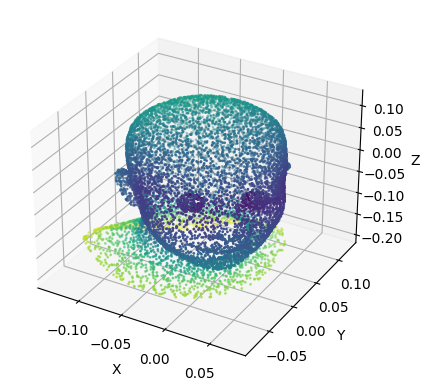

In [5]:
import numpy as np
from utils import rotate_x, rotate_z

# use matplotlib to visualize the point cloud
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

first_pcl = next(iter(train_dataset))['x']

# calculate the Euclidean distance for each point
distances = np.sqrt((first_pcl**2).sum(axis=1))

angle_x = -np.pi /  2.5
angle_z = -np.pi / 4

rotated_pcl = rotate_x(first_pcl, angle_x)
rotated_pcl = rotate_z(rotated_pcl, angle_z)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rotated_pcl[:, 0], rotated_pcl[:, 1], rotated_pcl[:, 2], c=distances, s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# add a colorbar to show the mapping between colors and distances
# plt.colorbar(scatter)

plt.show()

In [6]:
import open3d as o3d

point_cloud = o3d.geometry.PointCloud()

point_cloud.points = o3d.utility.Vector3dVector(rotated_pcl)

o3d.visualization.draw_geometries([point_cloud])

In [10]:
import open3d as o3d

# Assuming rotated_pcl is your point cloud data

point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(rotated_pcl)

# Save the point cloud to a file
o3d.io.write_point_cloud("point_cloud.ply", point_cloud)

vis = o3d.visualization.Visualizer()
vis.create_window(visible=True)
vis.get_render_option().background_color = np.asarray([0, 0, 0])
vis.add_geometry(point_cloud)

vis.run()

In [1]:
from utils import CustomDataset

class Test:
    def __init__(self):
        self.num_classes = 10
        self.num_points = 10000
        self.train_mode = "modified-modified"
    

train_dataset, test_dataset= CustomDataset('../../data_faces', Test())

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Attribute not found:  data


AttributeError: 

In [1]:
from utils import CustomDataset
dest = '../../data_faces'

train_dataset = CustomDataset(dest, num_points=10000, num_classes=32, train_mode="neutral-neutral", train=True)
train_dataset.find_classes()
train_dataset.create_data()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
train_dataset.data.__len__()

64

In [20]:
import numpy as np

first_pcl = next(iter(train_dataset))['x']
next_pcl = train_dataset[33]

first_pcl.shape


torch.Size([1024, 3])

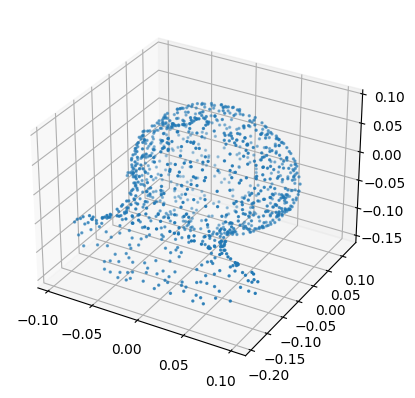

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(first_pcl[:, 0], first_pcl[:, 1], first_pcl[:, 2], s=2)
plt.show()

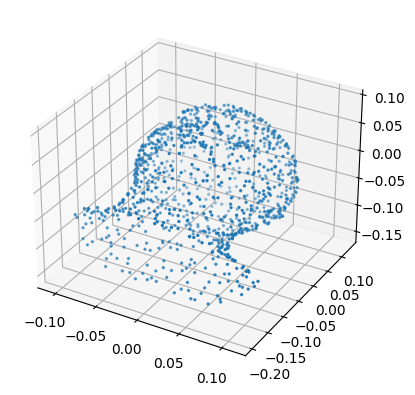

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(next_pcl['x'][:, 0], next_pcl['x'][:, 1], next_pcl['x'][:, 2], s=2)
plt.show()

In [ ]:
from utils import CustomDataset

dataset = CustomDataset("../../data_faces", num_classes=32, train_mode="neutral-modified")
dataset.find_classes()
dataset.create_data()
dataset.create_transforms()
dataset.create_cls_to_idx()

In [ ]:
len(dataset)

256

In [ ]:
for key, value in dataset.is_expression.items():
    print(key, value)

0 False
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 False
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 False
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 False
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 False
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 False
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 False
49 True
50 True
51 True
52 True
53 True
54 True
55 True
56 False
57 True
58 True
59 True
60 True
61 True
62 True
63 True
64 False
65 True
66 True
67 True
68 True
69 True
70 True
71 True
72 False
73 True
74 True
75 True
76 True
77 True
78 True
79 True
80 False
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 False
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 False
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 False
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 False
113 True
114 True
115 True
116 True
117 True
118 True
119 True
120 False
121 T